In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import h5py
import numpy as np
import pandas as pd
import logging
import re
from scipy.stats import pearsonr

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.8, style="whitegrid")

In [2]:
logger = logging.getLogger(__name__)
logging.basicConfig(format='[%(asctime)s - %(name)s] %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG,
                        handlers=[logging.StreamHandler()])

# Import run settings

In [3]:
def import_gdrive_sheet(gdrive_key, sheet_id):
    run_spreadsheet = pd.read_csv("https://docs.google.com/spreadsheet/ccc?key=" + \
                                  gdrive_key + "&output=csv&gid=" + sheet_id)
    if "date" in run_spreadsheet.columns:
        run_spreadsheet["date"] = run_spreadsheet["date"].astype(str)
    return run_spreadsheet

gdrive_key = "gsheet_id_here"
sheet_id = "0"
set_sheet_id = "512509543"

run_spreadsheet = import_gdrive_sheet(gdrive_key, sheet_id)
set_spreadsheet = import_gdrive_sheet(gdrive_key, set_sheet_id)

# Import training data

In [4]:
training_run_names = ["08_09_2019_run_01",
                      "08_13_2019_run_02",
                      "08_13_2019_run_03",
                      "08_15_2019_run_02",
                      "08_15_2019_run_03",
                      "08_16_2019_run_01",]

In [5]:
training_runs = run_spreadsheet[run_spreadsheet["run_name"].apply(lambda x: x in training_run_names)]

In [6]:
train_sw = []
for i, run_data in training_runs.iterrows():
    run_name = run_data["run_name"]
    label_file = run_data["filtered_sw_labels"]
    
    sw = pd.read_csv(label_file, sep="\t", index_col=0)
    sw["run_name"] = run_name
    train_sw.append(sw)
train_sw = pd.concat(train_sw)

# Import test sets

In [7]:
test_run_names = ["08_28_2019_run_01",
                  "08_30_2019_run_01",]

In [8]:
test_runs = run_spreadsheet[run_spreadsheet["run_name"].apply(lambda x: x in test_run_names)]

In [9]:
test_sw = []
for i, run_data in test_runs.iterrows():
    run_name = run_data["run_name"]
    label_file = run_data["filtered_sw_labels"]
    
    sw = pd.read_csv(label_file, sep="\t", index_col=0)
    sw["run_name"] = run_name
    test_sw.append(sw)
test_sw = pd.concat(test_sw)

# Import sequences & compute features

In [10]:
seqs_sheet_id = "1268399855"
seq_spreadsheet = import_gdrive_sheet(gdrive_key, seqs_sheet_id)
seq_spreadsheet.index = seq_spreadsheet["seq_no"]

In [11]:
seq_df = seq_spreadsheet.copy()

## Compute GC content

In [12]:
def find_gc_content(sequence):
    gc_content = 1. * (sequence.count("G") +
                       sequence.count("C")) / len(sequence)
    return gc_content

In [13]:
seq_df["GC"] = seq_df["seq"].apply(find_gc_content)

## Compute free energy ($\delta$G)

In [14]:
! export NUPACKHOME="/path/to/nupyck/lib/nupack"
import nupyck

In [15]:
def get_mfe(sequence, max_tries=100):
    tries = 0
    mfe = None
    while mfe is None and tries < max_tries:
        tries += 1
        try:
            options = nupyck.Options(material=nupyck.DNA)
            mfe = nupyck.mfe([sequence], [0], options=options)[0].get("energy")
        except IndexError:
            importlib.reload(nupyck)
            continue
    return mfe

In [16]:
seq_df["delta_g"] = seq_df["seq"].apply(get_mfe, max_tries=300)

In [17]:
seq_df

,seq_no,seq,GC,delta_g
seq_no,,,,
0,0,TTTATAGAAAACGTTTTGAAGAAGAAGATGATCTCTACTC,0.300,-1.120000e+00
1,1,TGTCCTACTATGTCTTCTCTCTTCTACTACTTACCTACTC,0.400,0.000000e+00
2,2,GGATGGATGATCCCACACCTCACACGCAGGAGAGAAACTC,0.550,-2.330000e+00
3,3,CTAGTGGTAGATGTTGTGTGTGGCGCGAGAGAAAGCACTC,0.525,-1.590000e+00
4,4,TTGCGACGATGACTGACGACTGCACGAAAAGCTGGAACTC,0.525,-1.210000e+00
5,5,GTGAGGAGGAGAAGTAAAAGAAAGCTTCGAGAGAGTACTC,0.450,-1.620000e+00
6,6,AGTTTACACGGCGCTCTTTCCGGTTTGATCTTGCACACTC,0.500,-1.810000e+00
7,7,CTGTTTGCACACACACCCGCACACCCTGTTCCCTCGACTC,0.600,-1.160000e+00
8,8,ATGCGTTGCGTTGTTTTGCGTTCCACACCACACGTTACTC,0.500,-6.800000e-01


## Max homopolymer length

In [18]:
def get_max_homopolymer_length(sequence):
    h_len = 1
    max_len = 1
    last_nt = None
    for nt in sequence:
        if last_nt == nt:
            h_len += 1
            max_len = max(max_len, h_len)
        else:
            h_len = 1
        last_nt = nt
    return max_len

In [20]:
seq_df["max_homopolymer_len"] = seq_df["seq"].apply(get_max_homopolymer_length)

In [21]:
seq_df

,seq_no,seq,GC,delta_g,max_homopolymer_len
seq_no,,,,,
0,0,TTTATAGAAAACGTTTTGAAGAAGAAGATGATCTCTACTC,0.300,-1.120000e+00,4
1,1,TGTCCTACTATGTCTTCTCTCTTCTACTACTTACCTACTC,0.400,0.000000e+00,2
2,2,GGATGGATGATCCCACACCTCACACGCAGGAGAGAAACTC,0.550,-2.330000e+00,3
3,3,CTAGTGGTAGATGTTGTGTGTGGCGCGAGAGAAAGCACTC,0.525,-1.590000e+00,3
4,4,TTGCGACGATGACTGACGACTGCACGAAAAGCTGGAACTC,0.525,-1.210000e+00,4
5,5,GTGAGGAGGAGAAGTAAAAGAAAGCTTCGAGAGAGTACTC,0.450,-1.620000e+00,4
6,6,AGTTTACACGGCGCTCTTTCCGGTTTGATCTTGCACACTC,0.500,-1.810000e+00,3
7,7,CTGTTTGCACACACACCCGCACACCCTGTTCCCTCGACTC,0.600,-1.160000e+00,3
8,8,ATGCGTTGCGTTGTTTTGCGTTCCACACCACACGTTACTC,0.500,-6.800000e-01,4


# Get train and test read counts

In [22]:
train_molbit_counts = []
train_norms = []
norm_train_molbit_counts = []
train_bits = []
for set_i, start_molbit in enumerate(range(0, 96, 16)):
    run_data = dict(training_runs[training_runs["molbit_set"] == set_i].iloc[0, :])
    run_name = run_data["run_name"]
        
    for half in [0, 1]:
        if half == 0:
            molbits_in_range = range(start_molbit, start_molbit+8)
        else:
            molbits_in_range = range(start_molbit+8, start_molbit+16)

        labels_from_run = train_sw[train_sw["run_name"] == run_name]
        filtered_labels_in_run = labels_from_run[labels_from_run["molbit"].apply(lambda x: x in molbits_in_range)]
        l, c = np.unique(filtered_labels_in_run["molbit"], return_counts=True)
        for l_, c_ in zip(l, c):
            train_molbit_counts.append(c_)
            norm_train_molbit_counts.append(c_ / sum(c))
        train_norms.append(sum(c))
        train_bits.append(molbits_in_range)

In [23]:
test_molbit_counts = []
test_norms = []
norm_test_molbit_counts = []
test_bits = []
for set_i, start_molbit in enumerate(range(0, 96, 16)):
    for half in [0, 1]:
        if half == 0:
            run_name = test_run_names[0]
            molbits_in_range = range(start_molbit, start_molbit+8)
        else:
            run_name = test_run_names[1]
            molbits_in_range = range(start_molbit+8, start_molbit+16)
        test_sw_run = test_sw[test_sw["run_name"] == run_name]
        filtered_labels_in_run = test_sw_run[test_sw_run["molbit"].apply(lambda x: x in molbits_in_range)]
        l, c = np.unique(filtered_labels_in_run["molbit"], return_counts=True)
        for l_, c_ in zip(l, c):
            test_molbit_counts.append(c_)
            norm_test_molbit_counts.append(c_ / sum(c))
        test_norms.append(sum(c))
        test_bits.append(molbits_in_range)
    

## Add counts to df

In [24]:
seq_df["norm_counts_train"] = norm_train_molbit_counts
seq_df["norm_counts_test"] = norm_test_molbit_counts
seq_df["counts_train"] = train_molbit_counts
seq_df["counts_test"] = test_molbit_counts

[14:28:18 - matplotlib.colorbar] locator: <matplotlib.ticker.MaxNLocator object at 0x7ff52ccd0518>
[14:28:18 - matplotlib.colorbar] Using auto colorbar locator on colorbar
[14:28:18 - matplotlib.colorbar] locator: <matplotlib.ticker.MaxNLocator object at 0x7ff52ccd0518>
[14:28:18 - matplotlib.colorbar] Setting pcolormesh
[14:28:18 - matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=19.8.
[14:28:18 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335
[14:28:18 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
[14:28:18 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
[14:28:18 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique nor

[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Carlito' (Carlito-Italic.ttf) italic normal 400 normal>) = 11.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'FreeSerif' (FreeSerifBoldItalic.ttf) italic normal bold normal>) = 11.335
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-ExtraLight.otf) normal normal light normal>) = 10.24
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Meera' (Meera.ttf) normal normal 400 normal>) = 10.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Lohit Gujarati' (Lohit-Gujarati.ttf) normal normal 400 normal>) = 10.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS75F.ttf) normal normal bold normal>) = 10.335
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'PakType Naqsh' (PakType_Naqsh.ttf) normal normal 400 normal>) = 10.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'FreeMono' (FreeMonoBold.ttf) normal 

[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Khmer OS System' (KhmerOS_sys.ttf) normal normal 400 normal>) = 10.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Noto Sans Tai Tham' (NotoSansTaiTham-Regular.ttf) normal normal 400 normal>) = 10.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Lohit Assamese' (Lohit-Assamese.ttf) normal normal 400 normal>) = 10.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'VL Gothic' (VL-Gothic-Regular.ttf) normal normal regular normal>) = 10.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Noto Sans Lisu' (NotoSansLisu-Regular.ttf) normal normal 400 normal>) = 10.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Carlito' (Carlito-Regular.ttf) normal normal 400 normal>) = 10.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal light normal>) = 2.24
[14:28:19 - matplotlib.font_manager] findfont: score(<Font

Text(0.5, 1, 'Correlations between\nsequence features and [test] read counts\n')

[14:28:19 - matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=21.6.
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>) = 3.335
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
[14:28:19 - matplotlib.fo

[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-ExtraLight.otf) normal normal light normal>) = 10.24
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Meera' (Meera.ttf) normal normal 400 normal>) = 10.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Lohit Gujarati' (Lohit-Gujarati.ttf) normal normal 400 normal>) = 10.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS75F.ttf) normal normal bold normal>) = 10.335
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'PakType Naqsh' (PakType_Naqsh.ttf) normal normal 400 normal>) = 10.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'FreeMono' (FreeMonoBold.ttf) normal normal bold normal>) = 10.335
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-Medium.otf) normal normal medium normal>) = 10.145
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Carlito' (Carlito-Bol

[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Lohit Assamese' (Lohit-Assamese.ttf) normal normal 400 normal>) = 10.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'VL Gothic' (VL-Gothic-Regular.ttf) normal normal regular normal>) = 10.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Noto Sans Lisu' (NotoSansLisu-Regular.ttf) normal normal 400 normal>) = 10.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Carlito' (Carlito-Regular.ttf) normal normal 400 normal>) = 10.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal light normal>) = 2.24
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Waree' (Waree-BoldOblique.ttf) oblique normal bold normal>) = 11.335
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'STIX' (STIX-Regular.otf) normal normal regular normal>) = 10.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Lohit Oriya' (Lohit-

[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'FreeSerif' (FreeSerif.ttf) normal normal 400 normal>) = 10.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'PT Sans Narrow' (PTN57F.ttf) normal normal 400 condensed>) = 10.25
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-Light.otf) normal normal light normal>) = 10.24
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Khmer OS Content' (KhmerOS_content.ttf) normal normal 400 normal>) = 10.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS76F.ttf) italic normal bold normal>) = 11.335
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS56F.ttf) italic normal 400 normal>) = 11.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Caladea' (Caladea-Italic.ttf) italic normal 400 normal>) = 11.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Cantarell' (Cantarell-BoldOblique.otf) oblique nor

[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Waree' (Waree-Oblique.ttf) oblique normal 400 normal>) = 11.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal bold normal>) = 4.335
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans TWHK' (SourceHanSansTWHK-Light.otf) normal normal light normal>) = 10.24
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal bold normal>) = 11.335
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Cantarell' (Cantarell-Bold.otf) normal normal bold normal>) = 10.335
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 4.05
[14:28:19 - matplotlib.font_manager] findfont: score(<Font 'NanumGothic' (NanumGothicExtraBold.ttf) normal normal bold normal>) = 10.335
[14:28:19 - matplotlib.font_manager] 

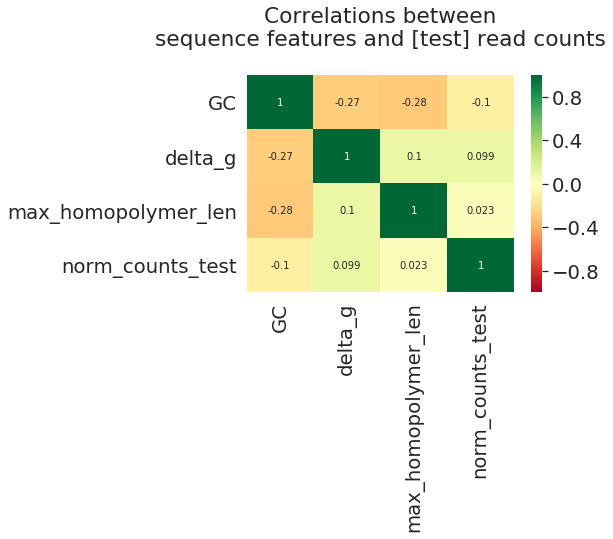

In [25]:
corrmat = seq_df.loc[:, ["GC", "delta_g", "max_homopolymer_len", "norm_counts_test"]].corr()
top_corr_features = corrmat.index
g = sns.heatmap(seq_df[top_corr_features].corr(),
                annot=True, cmap="RdYlGn", vmax=1, vmin=-1)
plt.title("Correlations between\nsequence features and [test] read counts\n")

[14:28:19 - matplotlib.colorbar] locator: <matplotlib.ticker.MaxNLocator object at 0x7ff52ccd0ac8>
[14:28:19 - matplotlib.colorbar] Using auto colorbar locator on colorbar
[14:28:19 - matplotlib.colorbar] locator: <matplotlib.ticker.MaxNLocator object at 0x7ff52ccd0ac8>
[14:28:19 - matplotlib.colorbar] Setting pcolormesh


Text(0.5, 1, 'Correlations between\nsequence features and [train] read counts\n')

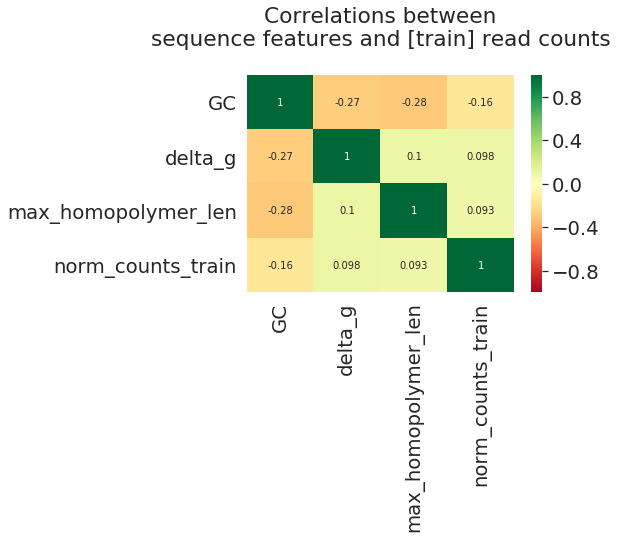

In [26]:
corrmat = seq_df.loc[:, ["GC", "delta_g", "max_homopolymer_len", "norm_counts_train"]].corr()
top_corr_features = corrmat.index
g = sns.heatmap(seq_df[top_corr_features].corr(),
                annot=True, cmap="RdYlGn", vmax=1, vmin=-1)
plt.title("Correlations between\nsequence features and [train] read counts\n")

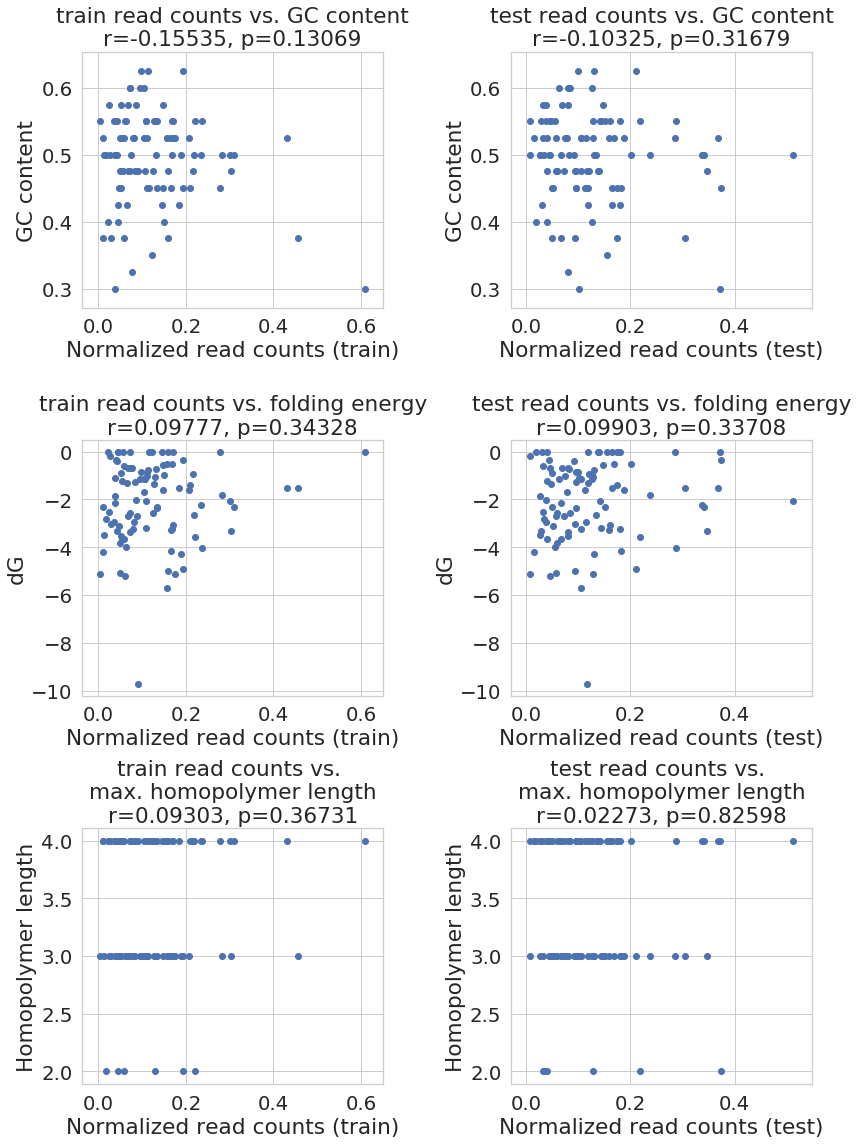

In [27]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 16))

### GC content
for col_i, t in enumerate(["train", "test"]):
    r, p = pearsonr(seq_df[f"norm_counts_{t}"], seq_df["GC"])
    ax[0, col_i].scatter(seq_df[f"norm_counts_{t}"], seq_df["GC"])
    ax[0, col_i].set_title(f"{t} read counts vs. GC content\nr={r:.5f}, p={p:.5f}")
    ax[0, col_i].set_xlabel(f"Normalized read counts ({t})")
    ax[0, col_i].set_ylabel("GC content")

### Free energy
for col_i, t in enumerate(["train", "test"]):
    r, p = pearsonr(seq_df[f"norm_counts_{t}"], seq_df["delta_g"])
    ax[1, col_i].scatter(seq_df[f"norm_counts_{t}"], seq_df["delta_g"])
    ax[1, col_i].set_title(f"{t} read counts vs. folding energy\nr={r:.5f}, p={p:.5f}")
    ax[1, col_i].set_xlabel(f"Normalized read counts ({t})")
    ax[1, col_i].set_ylabel("dG")
    
### Max homopolymer length
for col_i, t in enumerate(["train", "test"]):
    r, p = pearsonr(seq_df[f"norm_counts_{t}"], seq_df["max_homopolymer_len"])
    ax[2, col_i].scatter(seq_df[f"norm_counts_{t}"], seq_df["max_homopolymer_len"])
    ax[2, col_i].set_title(f"{t} read counts vs. \nmax. homopolymer length\nr={r:.5f}, p={p:.5f}")
    ax[2, col_i].set_xlabel(f"Normalized read counts ({t})")
    ax[2, col_i].set_ylabel("Homopolymer length")


fig.tight_layout()
fig.savefig("../plots/read_count_analysis/correlations.svg")

pearson r = -0.10325011545964223
p = 0.3167944391478653


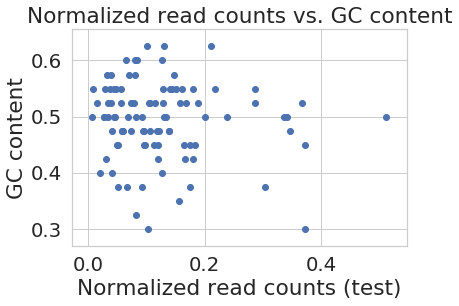

In [31]:
r, p = pearsonr(seq_df["norm_counts_test"], seq_df["GC"])
plt.scatter(seq_df["norm_counts_test"], seq_df["GC"])

print(f"pearson r = {r}")
print(f"p = {p}")
plt.title("Normalized read counts vs. GC content")
plt.xlabel("Normalized read counts (test)")
plt.ylabel("GC content")
fig.savefig("../plots/read_count_analysis/corr_test_v_GC.svg")

pearson r = 0.09903128434769216
p = 0.3370772183713898


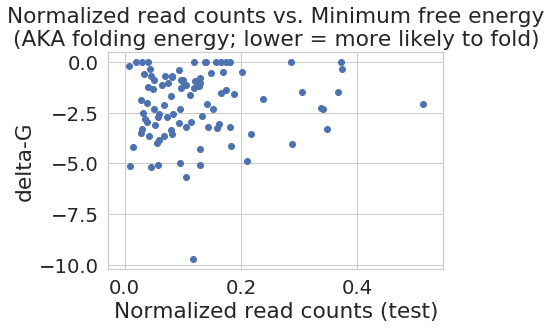

In [32]:
r, p = pearsonr(seq_df["norm_counts_test"], seq_df["delta_g"])
plt.scatter(seq_df["norm_counts_test"], seq_df["delta_g"])
# plt.plot([0, 0.6], [0, 0.6], c="k", alpha=0.2)
print(f"pearson r = {r}")
print(f"p = {p}")
plt.title("Normalized read counts vs. Minimum free energy\n(AKA folding energy; lower = more likely to fold)")
plt.xlabel("Normalized read counts (test)")
plt.ylabel("delta-G")
fig.savefig("../plots/read_count_analysis/corr_test_v_deltaG.svg")

pearson r = 0.022734277447366016
p = 0.8259801814213239


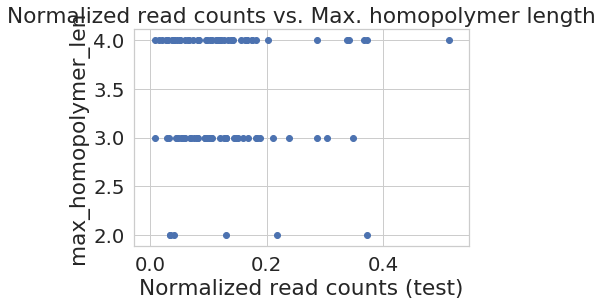

In [33]:
r, p = pearsonr(seq_df["norm_counts_test"], seq_df["max_homopolymer_len"])
plt.scatter(seq_df["norm_counts_test"], seq_df["max_homopolymer_len"])
# plt.plot([0, 0.6], [0, 0.6], c="k", alpha=0.2)
print(f"pearson r = {r}")
print(f"p = {p}")
plt.title("Normalized read counts vs. Max. homopolymer length")
plt.xlabel("Normalized read counts (test)")
plt.ylabel("max_homopolymer_len")
fig.savefig("../plots/read_count_analysis/corr_test_v_homlen.svg")